# Importing liberaries

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")


from tqdm import tqdm
import seaborn as sns
import pprint as pp

from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils

import numpy as np
import pandas as pd
import plotly.express as px
import os
import itertools

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model
import itertools
import cv2

from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout, Activation
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, \
     Dense, Input, Activation, Dropout, GlobalAveragePooling2D, AveragePooling2D
from keras.utils import to_categorical
from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from cv2 import imread, resize # manipulating the images
from tensorflow.keras.preprocessing.image import ImageDataGenerator






# loading data

In [6]:
base_skin_dir = os.path.join('..', 'input/skin-cancer-mnist-ham10000')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Loading Metadata (CSV file)

In [7]:
data = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

data['path'] = data['image_id'].map(imageid_path_dict.get)
data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
data['cell_type_idx'] = pd.Categorical(data['cell_type']).codes

data.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


# Preprocessing

### get the number of images

In [8]:
# Display the total found images.
print('Total number of images', len(data))
print('The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels')

Total number of images 10015
The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels


### mapping the data 

In [9]:
lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}
lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions ',
               'Basal cell carcinoma','Actinic keratoses','Vascular lesions',
               'Dermatofibroma']
lesion_names_short = ['nv','mel','bkl','bcc','akiec','vasc','df']

In [10]:
fname_images = np.array(data['image_id'])
file_to_read ='../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/'+str(fname_images[13])+'.jpg'

### Resize a sample and visualize it

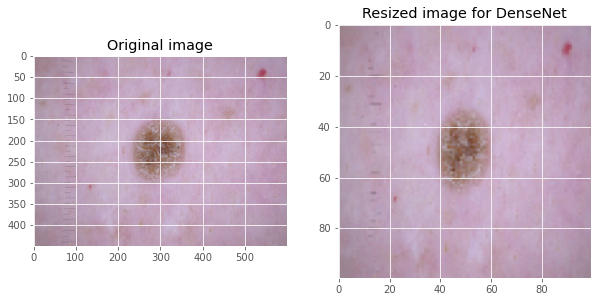

In [11]:
img = cv2.imread(file_to_read)
img2 = cv2.resize(img, (100, 100))
# Show one exampe image before and after
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, ::-1])
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(img2[:, :, ::-1])
plt.title('Resized image')
plt.show()

### Data augmentation

In [12]:

def produce_new_img(img2: cv2) -> tuple:
   
    # Rotate the image 90 degrees clockwise
    imga = cv2.rotate(img2, cv2.ROTATE_90_CLOCKWISE)

    # Rotate the image 90 degrees counterclockwise
    imgb = cv2.rotate(img2, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # Rotate the image 180 degrees
    imgc = cv2.rotate(img2, cv2.ROTATE_180)

    # Flip the image vertically
    imgd = cv2.flip(img2, 0)

    # Flip the image horizontally
    imge = cv2.flip(img2, 1)

    # Return the tuple of new images
    new_imges = imga, imgb, imgc, imgd, imge
    return new_imges


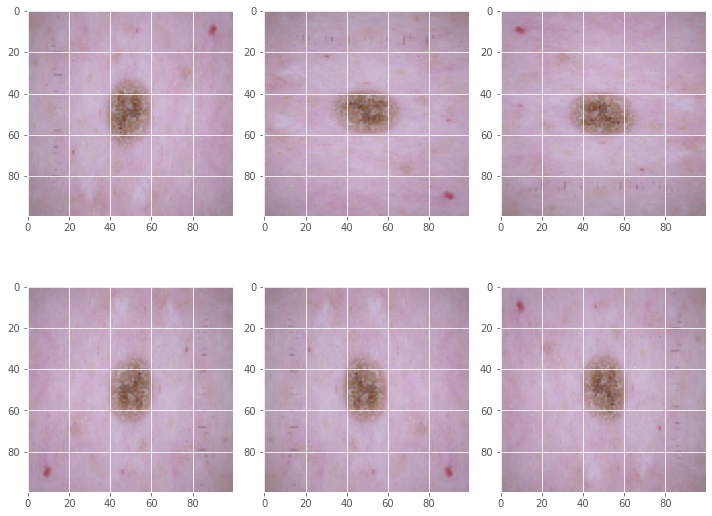

In [13]:
# visualizing the augmentation on one image
def show_example():
    plt.figure(figsize = (10, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(img2[:, :, ::-1])
    for i in range(5):
        plt.subplot(2, 3, 2+i)
        plt.imshow(new_img[i][:, :, ::-1])
    plt.tight_layout()
    plt.show()
new_img = produce_new_img(img2)

show_example()

In [16]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

### plotting number of samples with it's class

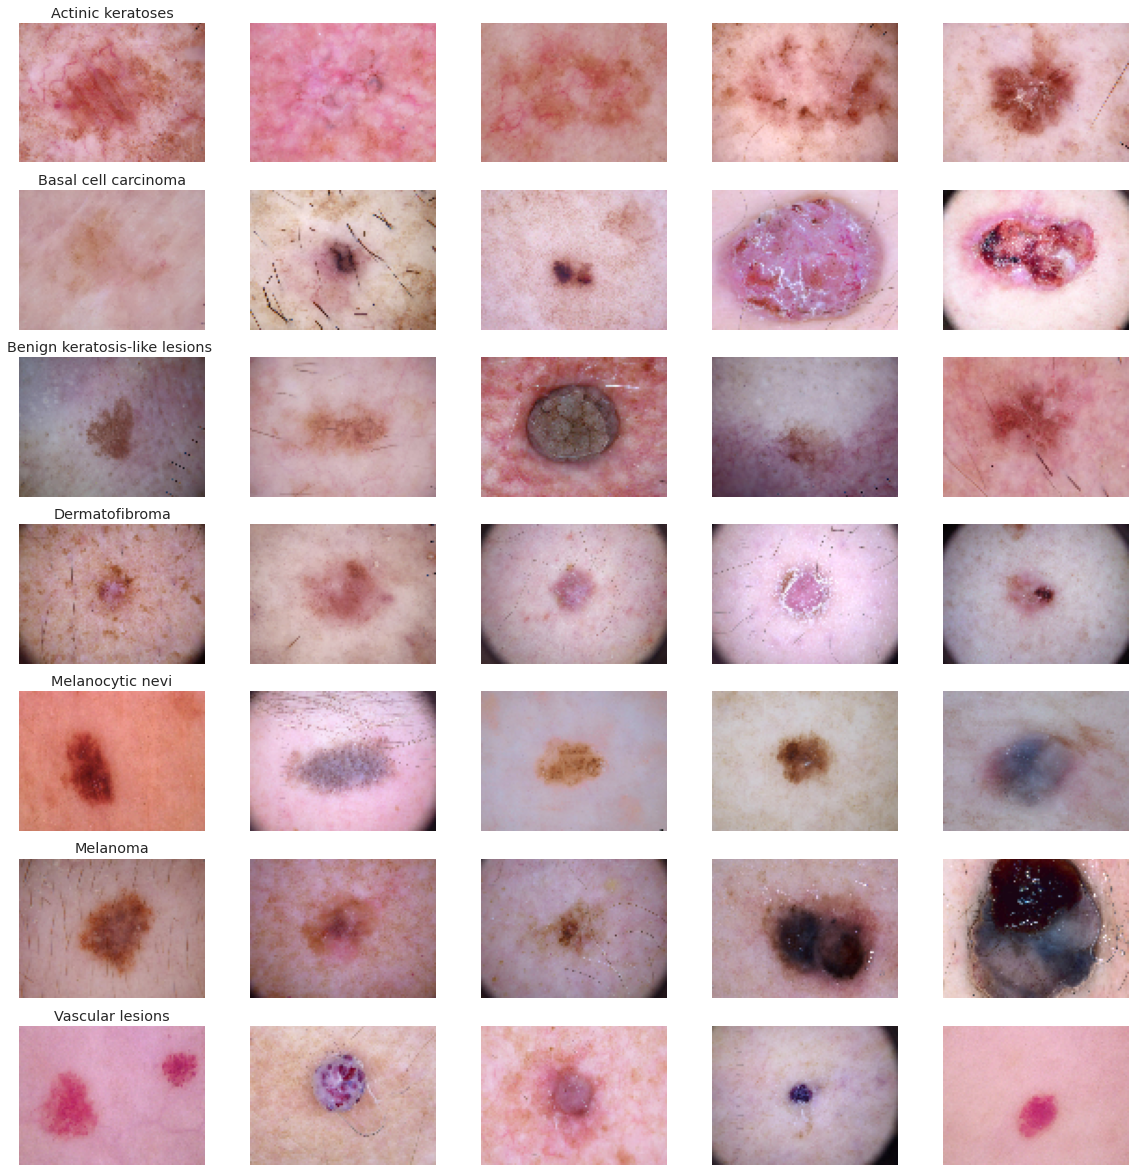

In [37]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

# Data Visualization

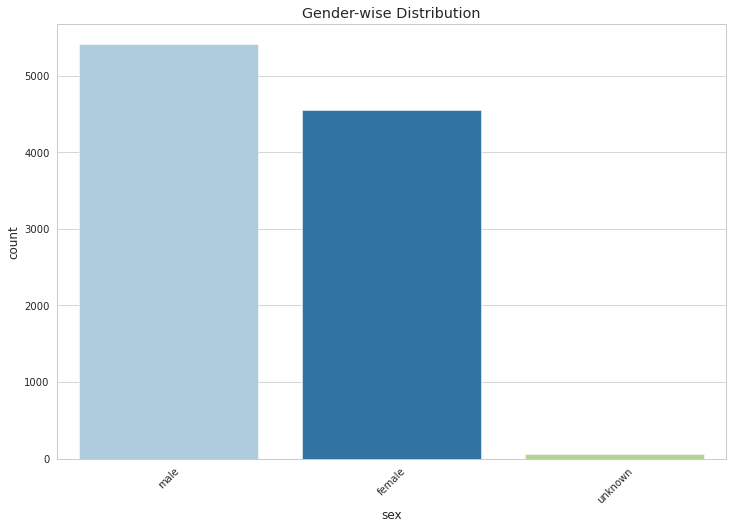

In [18]:
sns.set_style('whitegrid')
colors = ['#87ace8','#e3784d', 'green']
fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x='sex',data=data, palette = 'Paired')
# for container in ax.containers:
#     ax.bar_label(container)
plt.title('Gender-wise Distribution')
plt.xticks(rotation=45)
plt.show()

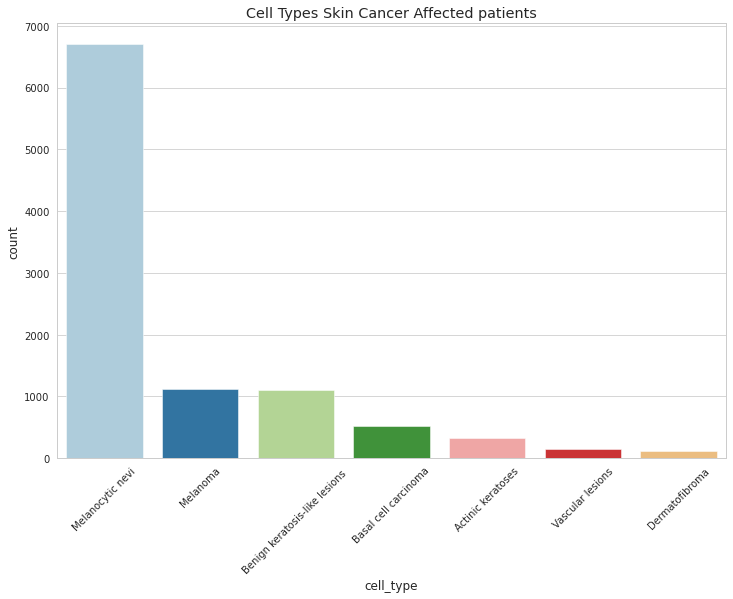

In [19]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type',data=data, order = data['cell_type'].value_counts().index, palette = 'Paired')
# for container in ax.containers:
#     ax.bar_label(container)
plt.title('Cell Types Skin Cancer Affected patients')
plt.xticks(rotation=45)
plt.show()

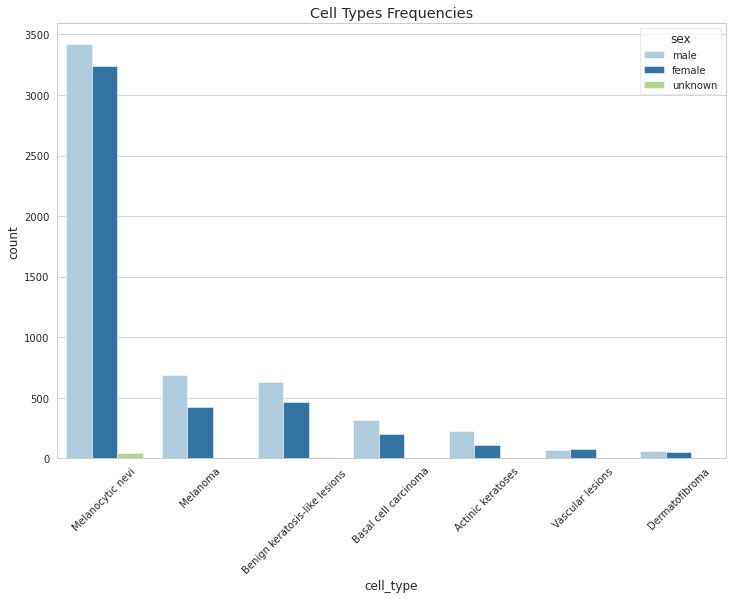

In [20]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type',hue='sex', data=data, order = data['cell_type'].value_counts().index, palette = 'Paired')
# for container in ax.containers:
#     ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

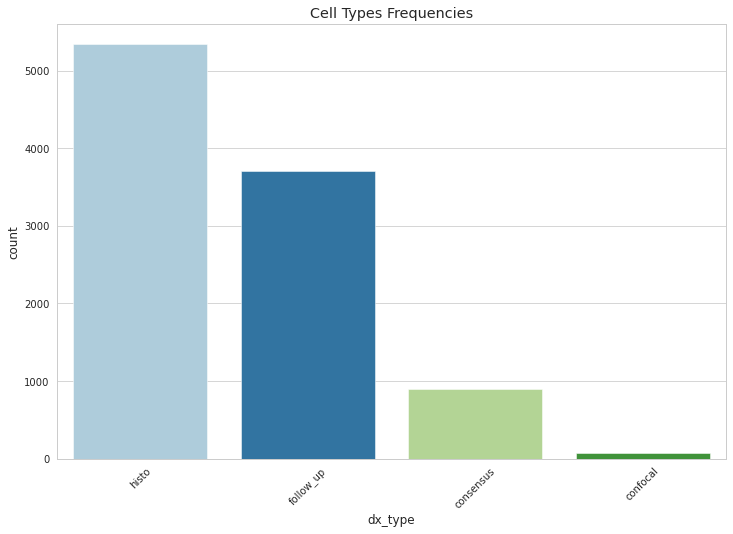

In [21]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type',data=data, order = data['dx_type'].value_counts().index, palette = 'Paired')
# for container in ax.containers:
#     ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

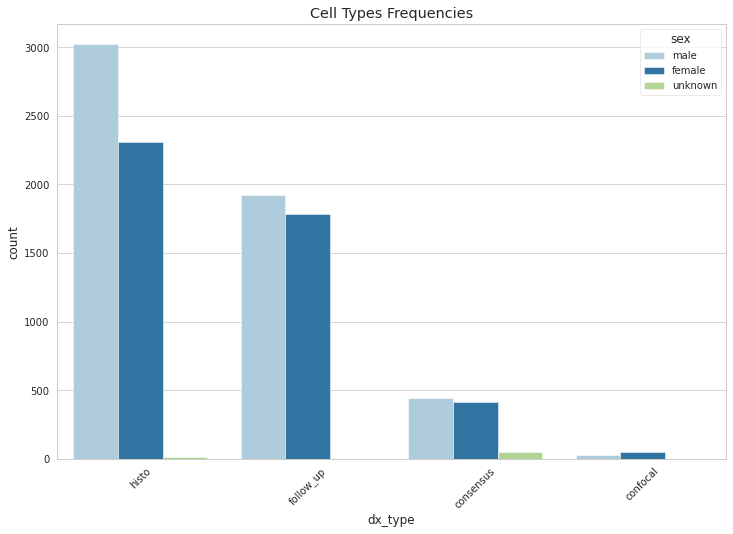

In [22]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type',hue='sex', data=data, order = data['dx_type'].value_counts().index, palette = 'Paired')
# for container in ax.containers:
#     ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

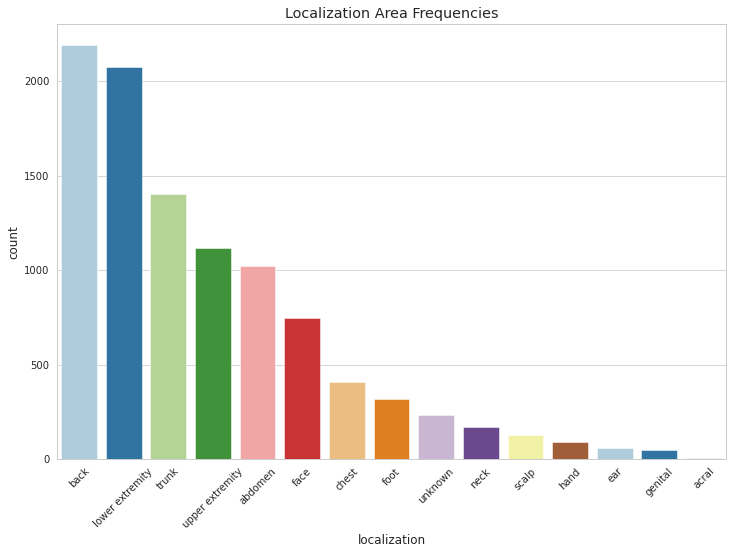

In [23]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',data=data, order = data['localization'].value_counts().index, palette = 'Paired')
# for container in ax.containers:
#     ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

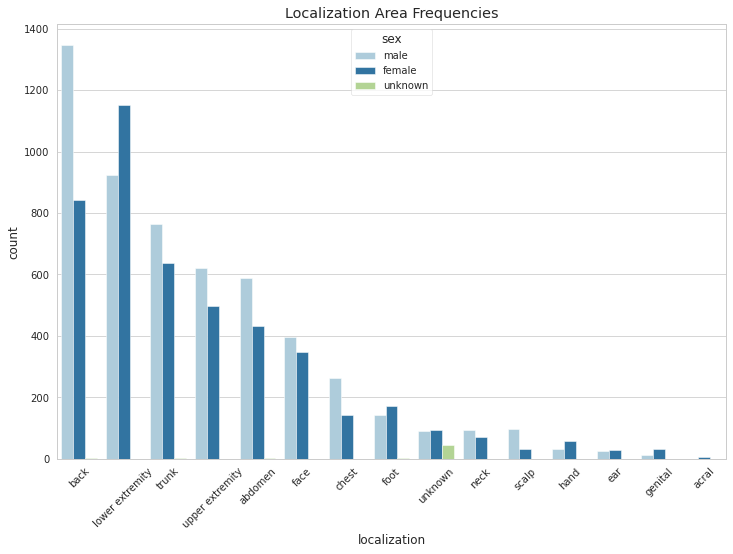

In [24]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',hue='sex', data=data, order = data['localization'].value_counts().index, palette = 'Paired')
# for container in ax.containers:
#     ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

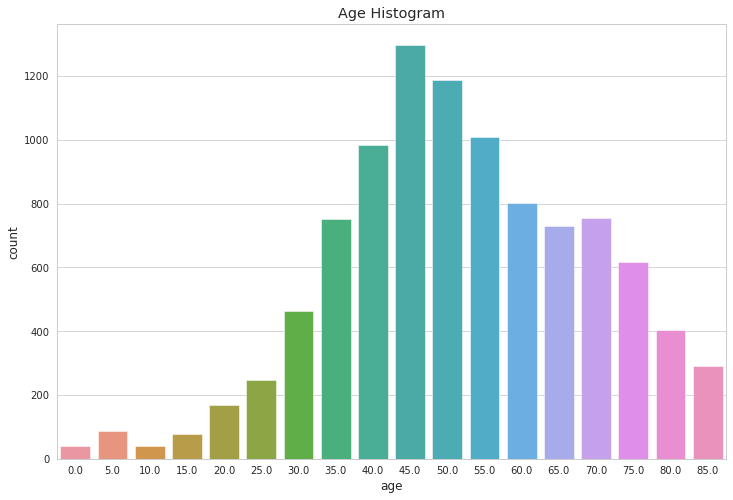

In [25]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(data=data, x='age')
plt.title('Age Histogram')
plt.show()

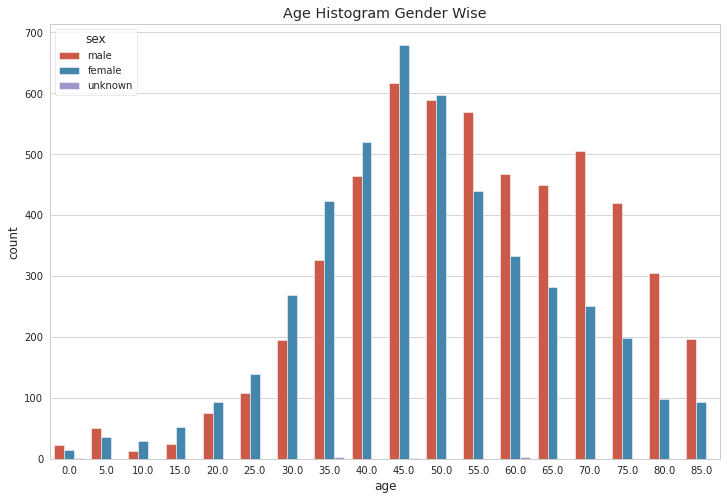

In [26]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(data=data, x='age',hue='sex')
plt.title('Age Histogram Gender Wise')
plt.show()

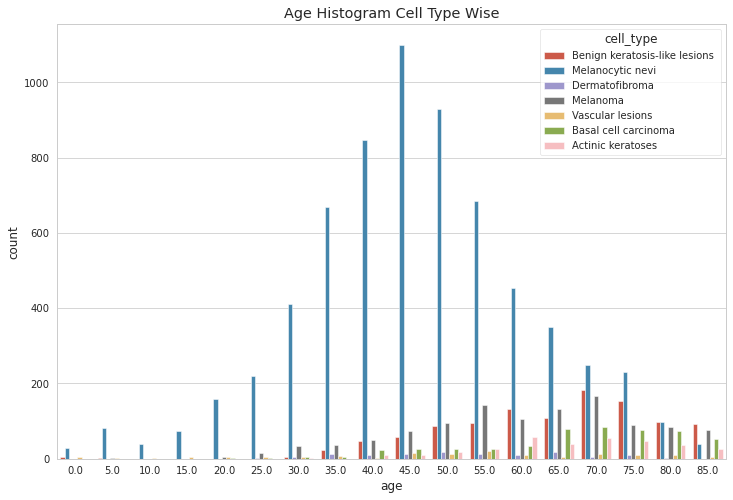

In [27]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(data=data, x='age',hue='cell_type')
plt.title('Age Histogram Cell Type Wise')
plt.show()

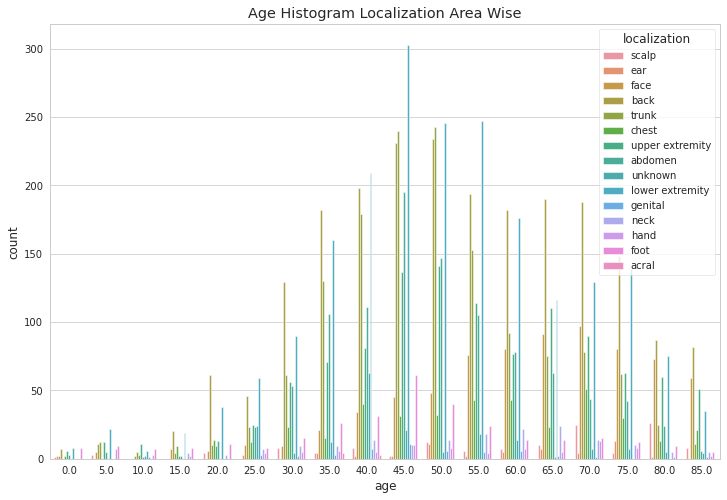

In [28]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(data=data, x='age',hue='localization')
plt.title('Age Histogram Localization Area Wise')
plt.show()

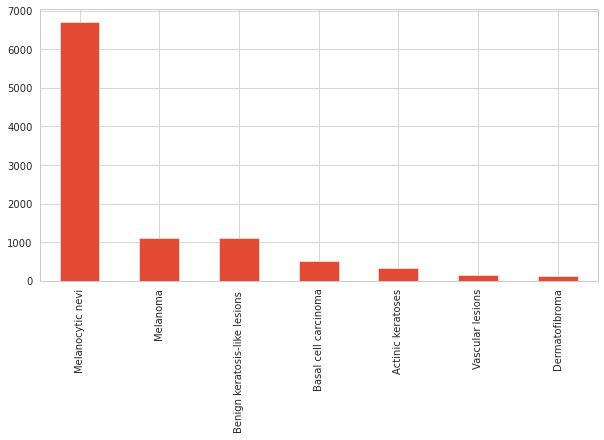

In [29]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
data['cell_type'].value_counts().plot(kind='bar', ax=ax1)

### Showing the weight for each class in our dataset

In [14]:
data['cell_type'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

# First C-NN model

In [15]:
x = []
y = []

lista1 = os.listdir('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/')
lista2 = os.listdir('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/')

for i in range(len(lista1)):
    
    fname_image = lista1[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/' + str(fname_image) 
    img = cv2.imread(file_to_read)                                  
    img2 = cv2.resize(img,(100, 100))                               
    x.append(img2)
    output = np.array(data[data['image_id'] == fname_ID].cell_type_idx)
    y.append(output[0])
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])

for i in range(len(lista2)):
    fname_image = lista2[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/' + str(fname_image)


    img = cv2.imread(file_to_read)
    img2 = cv2.resize(img, (100, 100))
    x.append(img2)
   
    output = np.array(data[data['image_id'] == fname_ID].cell_type_idx)
    y.append(output[0])
   
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])
    


In [16]:
x = np.array(x)
y = np.array(y)

y_train = to_categorical(y, num_classes = 7)


X_train, X_temp, y_train, y_temp = train_test_split(
    x,
    y_train,
    test_size=0.4,  # Adjust the size as needed
    random_state=42,
    stratify=y
)

# Split the temporary data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,  # Adjust the size as needed
    random_state=42,
    stratify=y_temp
)

# Now, X_train, X_val, and X_test are your training, validation, and test sets
# Similarly, y_train, y_val, and y_test are your corresponding labels

print('Train dataset shape', X_train.shape)
print('Test dataset shape', X_test.shape)

Train dataset shape (35073, 100, 100, 3)
Test dataset shape (11691, 100, 100, 3)


In [18]:
def est_class_weights(dis_id: np.array) -> dict:
    
    class_weights = np.around(compute_class_weight(class_weight = 'balanced', classes = np.unique(dis_id), y = y), 2)
    class_weights = dict(zip(np.unique(dis_id), class_weights))

y_id = np.array(data['cell_type_idx'])
new_class_weights = est_class_weights(y_id)
print(new_class_weights)

None


# Build the model

In [19]:
model = Sequential()
        

model.add(Conv2D(filters = 96,
                kernel_size = (11, 11),
                strides = (4, 4),
                activation = 'relu',
                input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))


model.add(Conv2D(filters = 256,
                kernel_size=(5, 5),
                strides=(1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))


model.add(Conv2D(filters = 384,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 padding="valid"))
model.add(BatchNormalization())


model.add(Conv2D(filters = 384,
                kernel_size = (1, 1), 
                strides = (1, 1), 
                activation = 'relu', 
                padding = "same"))
model.add(BatchNormalization())


model.add(Conv2D(filters = 256, 
                kernel_size = (1, 1),
                strides = (1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
              
model.add(Flatten()) 

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.4))
              

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.4))
              
model.add(Dense(7, activation = 'softmax'))

In [20]:
def mod_checkpoint_callback() -> None:
    
    trained_model = ModelCheckpoint(filepath = 'model.h5',  
                             save_weights_only = False,     
                             monitor = 'val_accuracy',      
                             mode = 'auto',                 
                             save_best_only = True,     
                             verbose = 1)
    return trained_model

In [51]:
early_stopping_monitor = EarlyStopping(patience = 35, monitor = 'val_accuracy')

model_checkpoint_callback = mod_checkpoint_callback()


optimizer = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-3)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

datagen = ImageDataGenerator(zoom_range = 0.3, horizontal_flip = True, shear_range = 0.3)
datagen.fit(X_train)

batch_size = 32
epochs = 35


history = model.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, model_checkpoint_callback],
                    validation_data = (X_val, y_val),
                    class_weight = new_class_weights
                )

Epoch 1/35
1097/1097 [==============================] - ETA: 0s - loss: 0.7732 - accuracy: 0.7187
Epoch 00001: val_accuracy improved from -inf to 0.72081, saving model to model.h5
1097/1097 [==============================] - 79s 72ms/step - loss: 0.7732 - accuracy: 0.7187 - val_loss: 0.7493 - val_accuracy: 0.7208
Epoch 2/35
1097/1097 [==============================] - ETA: 0s - loss: 0.6522 - accuracy: 0.7577
Epoch 00002: val_accuracy did not improve from 0.72081
1097/1097 [==============================] - 78s 71ms/step - loss: 0.6522 - accuracy: 0.7577 - val_loss: 0.8157 - val_accuracy: 0.7129
Epoch 3/35
1097/1097 [==============================] - ETA: 0s - loss: 0.6204 - accuracy: 0.7658
Epoch 00003: val_accuracy improved from 0.72081 to 0.75289, saving model to model.h5
1097/1097 [==============================] - 79s 72ms/step - loss: 0.6204 - accuracy: 0.7658 - val_loss: 0.6505 - val_accuracy: 0.7529
Epoch 4/35
1097/1097 [==============================] - ETA: 0s - loss: 0.5874 

### Evalate the first C-NN model

In [52]:
scores = model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

366/366 [==============================] - 1s 4ms/step - loss: 0.3980 - accuracy: 0.8743
Accuracy: 87.43%


In [22]:
from tensorflow_addons.losses import SigmoidFocalCrossEntropy

# Second C-NN Model

#### with changing the loss function 

In [24]:
early_stopping_monitor = EarlyStopping(patience = 35, monitor = 'val_accuracy')

model_checkpoint_callback = mod_checkpoint_callback()


optimizer = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-3)
model.compile(optimizer = optimizer, loss = SigmoidFocalCrossEntropy(), metrics = ['accuracy'])

datagen = ImageDataGenerator(zoom_range = 0.3, horizontal_flip = True, shear_range = 0.3)
datagen.fit(X_train)

batch_size = 32
epochs = 35


history = model.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, model_checkpoint_callback],
                    validation_data = (X_val, y_val),
                    class_weight = new_class_weights
                )

Epoch 1/35
1097/1097 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.7137
Epoch 00001: val_accuracy improved from -inf to 0.68856, saving model to model.h5
1097/1097 [==============================] - 80s 73ms/step - loss: 0.1494 - accuracy: 0.7137 - val_loss: 0.6374 - val_accuracy: 0.6886
Epoch 2/35
1097/1097 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.7515
Epoch 00002: val_accuracy did not improve from 0.68856
1097/1097 [==============================] - 79s 72ms/step - loss: 0.1253 - accuracy: 0.7515 - val_loss: 0.2006 - val_accuracy: 0.5632
Epoch 3/35
1097/1097 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.7657
Epoch 00003: val_accuracy improved from 0.68856 to 0.70678, saving model to model.h5
1097/1097 [==============================] - 80s 73ms/step - loss: 0.1179 - accuracy: 0.7657 - val_loss: 0.1830 - val_accuracy: 0.7068
Epoch 4/35
1097/1097 [==============================] - ETA: 0s - loss: 0.1125 

Evalate the second C-NN model

In [25]:
scores = model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

366/366 [==============================] - 1s 4ms/step - loss: 0.0479 - accuracy: 0.9131
Accuracy: 91.31%


### Plotting of the model with higher accuracy

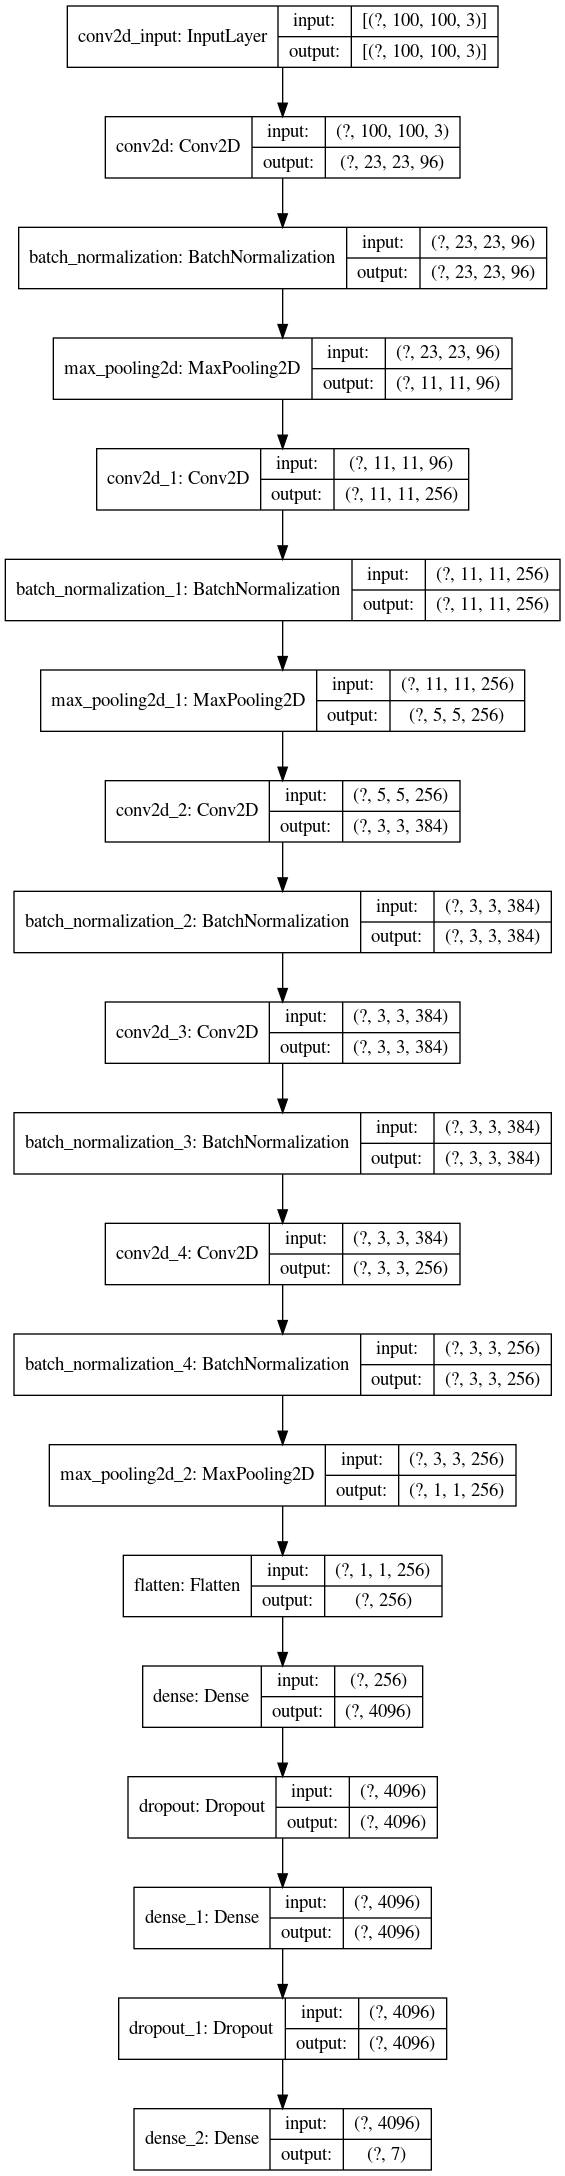

In [26]:
from keras.utils import plot_model

# Visualize the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Images will be rescaled to (128,128,3) and standardized (division by 255)

# Load the data for the first transfer learning model

In [15]:
def load_img_data(size, df, balanced=False):
    """
        ..
        first we should normalize the image from 0-255 to 0-1
    """
    
    img_h, img_w = size, size
    imgs = []
    
    if balanced:
        df = balanced_dataset(df)
    
    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        #img = np.asarray(Image.open(image_paths[i]).resize((size,size)))
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)

    #imgs = imgs.astype(np.float32) / 255.
    
    return imgs, df['cell_type_idx'].values

In [16]:
imgs, target   = load_img_data(128, data, balanced=False)

100%|██████████| 10015/10015 [02:42<00:00, 61.51it/s]


(10015, 128, 128, 3)


### Split the data for training and testing and validation 

In [17]:
x_train, x_test, y_train, y_test = train_test_split(imgs, target, test_size=0.20)
x_train, x_val, y_train, y_val = train_test_split(imgs, target, test_size=0.05)

train_val_test = (x_train, y_train, x_val, y_val, x_test, y_test)

[x_train.shape, x_val.shape, x_test.shape]

[(9514, 128, 128, 3), (501, 128, 128, 3), (2003, 128, 128, 3)]

# DenseNet201 Model build

In [18]:
class denseNet201_class(object):

    def __init__(self, data, architecture, hidden_layers, classes, epochs, batch_size):
        self.input_shape = data[0][0].shape

        self.base_arch = architecture
        self.nn = self.download_network()
        self.nn.trainable = False

        self.hidden_layers = hidden_layers
        
        self.classes = classes

        self.trainX = data[0]
        self.trainY = data[1]
        self.valX = data[2]
        self.valY = data[3]
        self.testX = data[4]
        self.testY = data[5]

        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size

        self.model = self.build()
        self.train_generator = self.data_augmentation()
        self.predictions = None
        self.score = None

        self.best_weights = None

    def download_network(self):
        '''
        Download the requested CNN with imagenet weights
        '''
        nn = None
        nn = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=self.input_shape)

        return nn

    def run(self):
        '''
        Main driver for Learner object
        '''
        self.fine_tune()
        #self.load_weights(self.best_weights)
        #self.predict()

    def build(self):
        '''
        Build model. Add Dense layer to topless base CNN.
        '''

        model = tf.keras.models.Sequential()
        model.add(self.nn)
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(0.25))
        
        for layer in self.hidden_layers:
            model.add(tf.keras.layers.Dense(layer, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Dropout(0.46))  

        model.add(tf.keras.layers.Dense(self.classes, activation='softmax'))
        
        print (model.summary())

        return model

    def load_weights(self, name):
        '''
        Load the best checkpointed weights.
        '''
        print('\nLoading best accuracy weights.')
        self.model.load_weights(name)

    def data_augmentation(self):
        data_gen_args = dict(
                rotation_range=10,
                zoom_range=0.1,
                horizontal_flip=True,
                vertical_flip=True,
            )

        train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
        train_generator = train_gen.flow(self.trainX, self.trainY, batch_size=self.BATCH_SIZE)

        return train_generator

    def get_class_weight(self):

        weight_for_0 = (1 / (self.trainY == 0).sum())*(len(self.trainY))/7.0 
        weight_for_1 = (1 / (self.trainY == 1).sum())*(len(self.trainY))/7.0
        weight_for_2 = (1 / (self.trainY == 2).sum())*(len(self.trainY))/7.0 
        weight_for_3 = (1 / (self.trainY == 3).sum())*(len(self.trainY))/7.0
        weight_for_4 = (1 / (self.trainY == 4).sum())*(len(self.trainY))/7.0 
        weight_for_5 = (1 / (self.trainY == 5).sum())*(len(self.trainY))/7.0
        weight_for_6 = (1 / (self.trainY == 6).sum())*(len(self.trainY))/7.0

        class_weight = {
            0: weight_for_0, 
            1: weight_for_1,
            2: weight_for_2, 
            3: weight_for_3,
            4: weight_for_4, 
            5: weight_for_5,
            6: weight_for_6, 
        }

        print('Class_weights:\n', class_weight, '\n')
        
        return class_weight

    def fine_tune(self):
        '''
        Fine-tune network in 2 phases
        '''

        numTrainingSamples = self.trainX.shape[0]
        numValidationSamples = self.valX.shape[0]

        print ("\nPhase A - Training Fully Connected Layers\n")
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

        # Define checkpoint to save best Phase 1 weights
        best_weights_ph1 = self.base_arch + "_ph1_weights.hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
        
        history = self.model.fit(
            x_train, y_train,
            #self.train_generator,
            steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=(self.valX, self.valY),
            validation_steps=numValidationSamples // self.BATCH_SIZE,
            #class_weight=self.get_class_weight(),
            callbacks=[checkpoint])
        
        # Store the best phase 1 accuracy
        best_acc_ph1 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph1)

        print('\nRestoring best weights and predicting validation set.')
        self.load_weights(best_weights_ph1)

        # Make predictions based on best phase 1 weights
        self.predict()

        self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph A')
        

        print ("\nPhase B  - Fine Tune all Layers \n")
        # Set full original CNN as trainable
        self.nn.trainable = True

        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-5), metrics=['accuracy'])

        # Define checkpoint to save best Phase 2 weights
        best_weights_ph2 = self.base_arch + "_ph2_weights.hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph2, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

        # Fine-tune the full CNN + FC
        history = self.model.fit(
            x_train, y_train,
            #self.train_generator,
            steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=(self.valX, self.valY),
            validation_steps=numValidationSamples // self.BATCH_SIZE,
            #class_weight=self.get_class_weight(),
            callbacks=[checkpoint])

        # Store the best phase 2 accuracy
        best_acc_ph2 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph2)

        # Only if Phase 2 fine-tuning resulted in a better accuracy than phase 1,
        # restore best phase 2 weights and update Tuner predictions.
        if best_acc_ph2 > best_acc_ph1:
            print('\nPhase 2 resulted in better accuracy than Phase 1.')
            print('Restoring best weights of Ph2 and predicting validation set.')
            self.load_weights(best_weights_ph2)
            self.predict()

        self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph B')
    
    def predict(self):
        '''
        Get predictions and score for validation set.
        '''
        print('\nPredicting test set classes.')
        self.score = self.model.evaluate(self.testX, self.testY, verbose=0)
        print('Test set score:', self.score)
        self.predictions = self.model.predict(self.testX, batch_size=self.BATCH_SIZE)
        print('Done')

    def plot_loss(self, history, epochs, name):
        print('\n\n')
        plt.figure(figsize=(12,8))
        plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
        plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
        plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
        plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
        plt.title("Training Loss and Accuracy - {}".format(name))
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend()
        plt.show()


### Training on DenseNet201

74842112/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 4, 4, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 30720)             0         
_________________________________________________________________
dropout (Dropout)            (None, 30720)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               15729152  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________

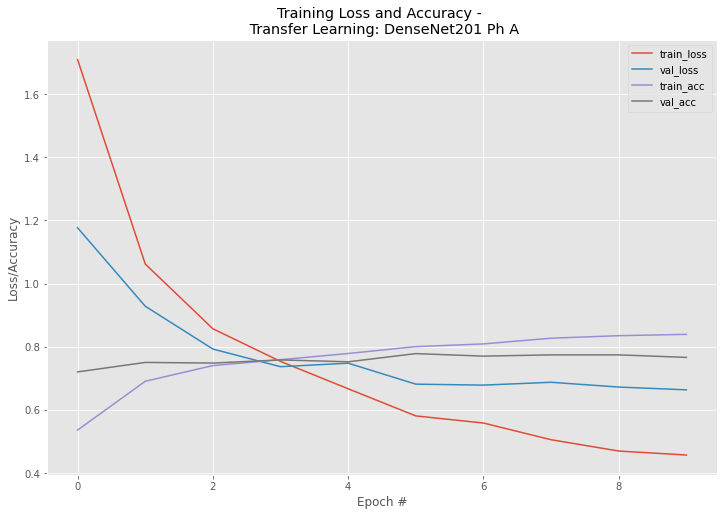


Phase B  - Fine Tune all Layers 

Epoch 1/10
74/74 [==============================] - ETA: 0s - loss: 1.3335 - accuracy: 0.6651
Epoch 00001: val_loss improved from inf to 0.88930, saving model to DenseNet201_ph2_weights.hdf5
74/74 [==============================] - 36s 493ms/step - loss: 1.3335 - accuracy: 0.6651 - val_loss: 0.8893 - val_accuracy: 0.7345
Epoch 2/10
74/74 [==============================] - ETA: 0s - loss: 0.8558 - accuracy: 0.7464
Epoch 00002: val_loss did not improve from 0.88930
74/74 [==============================] - 29s 388ms/step - loss: 0.8558 - accuracy: 0.7464 - val_loss: 0.9599 - val_accuracy: 0.7405
Epoch 3/10
74/74 [==============================] - ETA: 0s - loss: 0.6634 - accuracy: 0.7874
Epoch 00003: val_loss did not improve from 0.88930
74/74 [==============================] - 29s 388ms/step - loss: 0.6634 - accuracy: 0.7874 - val_loss: 0.9860 - val_accuracy: 0.7265
Epoch 4/10
74/74 [==============================] - ETA: 0s - loss: 0.5222 - accuracy: 0

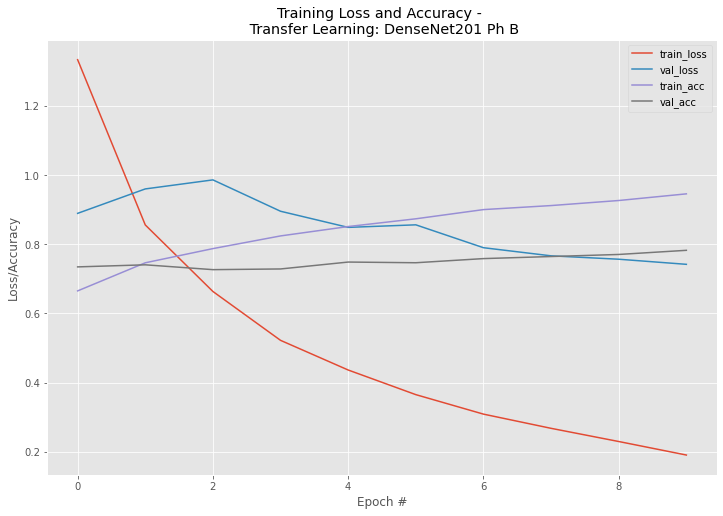

In [19]:
NET = 'DenseNet201'
HIDDEN_LAYERS = [512, 128]
#HIDDEN_LAYERS = [256, 256, 64]
CLASSES = len(set(target))
BATCH_SIZE = 128
EPOCHS = 10

model = denseNet201_class(train_val_test, NET, HIDDEN_LAYERS, CLASSES, EPOCHS, BATCH_SIZE)
model.run()

In [20]:
model.predict()


Predicting test set classes.
Test set score: [0.12015082687139511, 0.9790314435958862]
Done


### Confusion matrix of DenseNet201

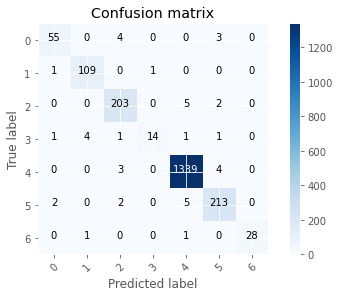

In [21]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Predict the values from the validation dataset
Y_pred = model.predictions
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
#Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 


### Load the data for the second transfer learning model

In [23]:
def load_img_data(size, df, balanced=False):
    """
        ..
        first we should normalize the image from 0-255 to 0-1
    """
    
    img_h, img_w = size, size
    imgs = []
    
    if balanced:
        df = balanced_dataset(df)
    
    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        #img = np.asarray(Image.open(image_paths[i]).resize((size,size)))
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)

    #imgs = imgs.astype(np.float32) / 255.
    
    return imgs, df['cell_type_idx'].values


In [24]:
imgs, target   = load_img_data(128, data, balanced=False)

100%|██████████| 10015/10015 [01:41<00:00, 98.21it/s] 


(10015, 128, 128, 3)


In [25]:
x_train, x_test, y_train, y_test = train_test_split(imgs, target, test_size=0.20)
x_test, x_val, y_test, y_val = train_test_split(imgs, target, test_size=0.1)

train_val_test = (x_train, y_train, x_val, y_val, x_test, y_test)

[x_train.shape, x_val.shape, x_test.shape]

[(8012, 128, 128, 3), (1002, 128, 128, 3), (9013, 128, 128, 3)]

# Build VGG16 model

In [26]:
class VGG16_class(object):

    def __init__(self, data, architecture, hidden_layers, classes, epochs, batch_size):
        self.input_shape = data[0][0].shape

        self.base_arch = architecture
        self.nn = self.download_network()
        self.nn.trainable = False

        self.hidden_layers = hidden_layers
        
        self.classes = classes

        self.trainX = data[0]
        self.trainY = data[1]
        self.valX = data[2]
        self.valY = data[3]
        self.testX = data[4]
        self.testY = data[5]

        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size

        self.model = self.build()
        self.train_generator = self.data_augmentation()
        self.predictions = None
        self.score = None

        self.best_weights = None

    def download_network(self):
        '''
        Download the requested CNN with imagenet weights
        '''
        nn = None
        nn = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=self.input_shape)

        return nn

    def run(self):
        '''
        Main driver for Learner object
        '''
        self.fine_tune()
        #self.load_weights(self.best_weights)
        #self.predict()

    def build(self):
        '''
        Build model. Add Dense layer to topless base CNN.
        '''

        model = tf.keras.models.Sequential()
        model.add(self.nn)
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(0.25))
        
        for layer in self.hidden_layers:
            model.add(tf.keras.layers.Dense(layer, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Dropout(0.46))  

        model.add(tf.keras.layers.Dense(self.classes, activation='softmax'))
        
        print (model.summary())

        return model

    def load_weights(self, name):
        '''
        Load the best checkpointed weights.
        '''
        print('\nLoading best accuracy weights.')
        self.model.load_weights(name)

    def data_augmentation(self):
        data_gen_args = dict(
                rotation_range=10,
                zoom_range=0.1,
                horizontal_flip=True,
                vertical_flip=True,
            )

        train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
        train_generator = train_gen.flow(self.trainX, self.trainY, batch_size=self.BATCH_SIZE)

        #print('\nData augmentation with the following parameters:')
        #pp.pprint(data_gen_args)

        return train_generator

    def get_class_weight(self):

        weight_for_0 = (1 / (self.trainY == 0).sum())*(len(self.trainY))/7.0 
        weight_for_1 = (1 / (self.trainY == 1).sum())*(len(self.trainY))/7.0
        weight_for_2 = (1 / (self.trainY == 2).sum())*(len(self.trainY))/7.0 
        weight_for_3 = (1 / (self.trainY == 3).sum())*(len(self.trainY))/7.0
        weight_for_4 = (1 / (self.trainY == 4).sum())*(len(self.trainY))/7.0 
        weight_for_5 = (1 / (self.trainY == 5).sum())*(len(self.trainY))/7.0
        weight_for_6 = (1 / (self.trainY == 6).sum())*(len(self.trainY))/7.0

        class_weight = {
            0: weight_for_0, 
            1: weight_for_1,
            2: weight_for_2, 
            3: weight_for_3,
            4: weight_for_4, 
            5: weight_for_5,
            6: weight_for_6, 
        }

        print('Class_weights:\n', class_weight, '\n')
        
        return class_weight

    def fine_tune(self):
        '''
        Fine-tune network in 2 phases
        '''

        numTrainingSamples = self.trainX.shape[0]
        numValidationSamples = self.valX.shape[0]

        print ("\nPhase A - Training Fully Connected Layers\n")
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

        # Define checkpoint to save best Phase 1 weights
        best_weights_ph1 = self.base_arch + "_ph1_weights.hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
        
        history = self.model.fit(
            x_train, y_train,
            #self.train_generator,
            steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=(self.valX, self.valY),
            validation_steps=numValidationSamples // self.BATCH_SIZE,
            #class_weight=self.get_class_weight(),
            callbacks=[checkpoint])
        
        # Store the best phase 1 accuracy
        best_acc_ph1 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph1)

        print('\nRestoring best weights and predicting validation set.')
        self.load_weights(best_weights_ph1)

        # Make predictions based on best phase 1 weights
        self.predict()

        self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch )
   

    def predict(self):
        '''
        Get predictions and score for validation set.
        '''
        print('\nPredicting test set classes.')
        self.score = self.model.evaluate(self.testX, self.testY, verbose=0)
        print('Test set score:', self.score)
        self.predictions = self.model.predict(self.testX, batch_size=self.BATCH_SIZE)
        print('Done')

    def plot_loss(self, history, epochs, name):
        print('\n\n')
        plt.figure(figsize=(12,8))
        plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
        plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
        plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
        plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
        plt.title("Training Loss and Accuracy - {}".format(name))
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend()
        plt.show()


58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_______________________________________________________

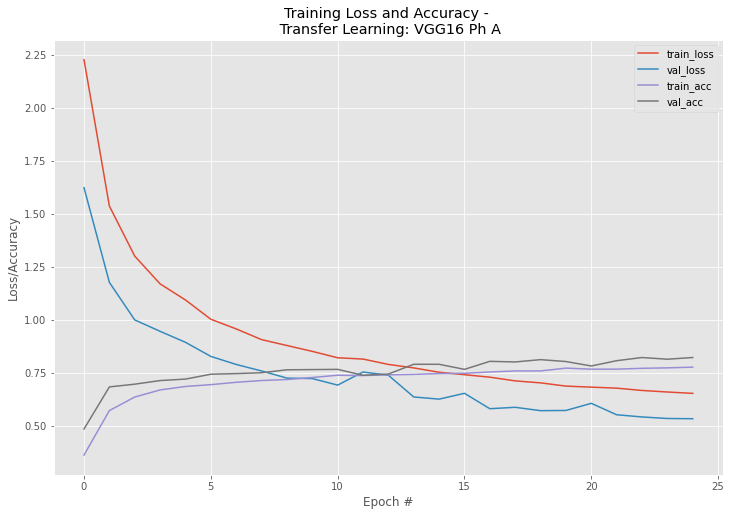


Phase B  - Fine Tune all Layers 

Epoch 1/25
40/40 [==============================] - ETA: 0s - loss: 0.6284 - accuracy: 0.7872
Epoch 00001: val_loss improved from inf to 0.55098, saving model to VGG16_ph2_weights.hdf5
40/40 [==============================] - 20s 509ms/step - loss: 0.6284 - accuracy: 0.7872 - val_loss: 0.5510 - val_accuracy: 0.8194
Epoch 2/25
40/40 [==============================] - ETA: 0s - loss: 0.5800 - accuracy: 0.8017
Epoch 00002: val_loss improved from 0.55098 to 0.48043, saving model to VGG16_ph2_weights.hdf5
40/40 [==============================] - 18s 461ms/step - loss: 0.5800 - accuracy: 0.8017 - val_loss: 0.4804 - val_accuracy: 0.8453
Epoch 3/25
40/40 [==============================] - ETA: 0s - loss: 0.5526 - accuracy: 0.8099
Epoch 00003: val_loss improved from 0.48043 to 0.46705, saving model to VGG16_ph2_weights.hdf5
40/40 [==============================] - 19s 463ms/step - loss: 0.5526 - accuracy: 0.8099 - val_loss: 0.4670 - val_accuracy: 0.8493
Epoch 

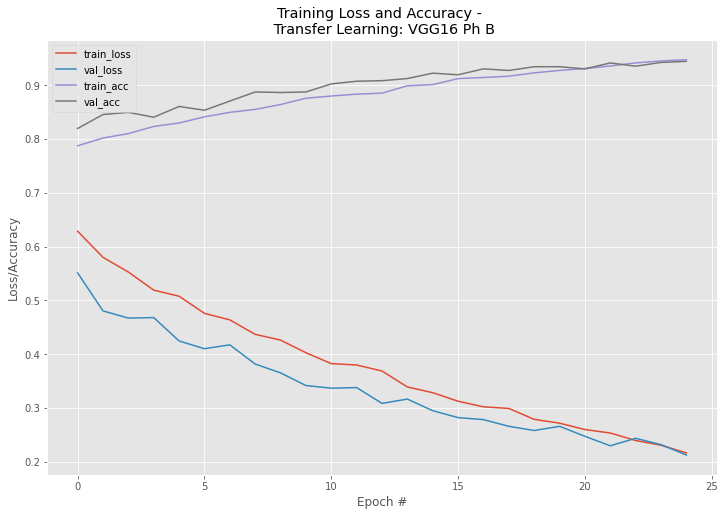

In [27]:
NET = 'VGG16'
HIDDEN_LAYERS = [512, 128]
HIDDEN_LAYERS = [256, 256, 64]
CLASSES = len(set(target))
BATCH_SIZE = 200
EPOCHS = 25

model = Tuner(train_val_test, NET, HIDDEN_LAYERS, CLASSES, EPOCHS, BATCH_SIZE)
model.run()

In [28]:
model.predict()


Predicting test set classes.
Test set score: [0.20060928165912628, 0.9490735530853271]
Done


### Confusin matrix of VGG16

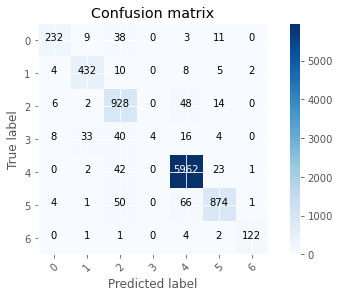

In [29]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Predict the values from the validation dataset
Y_pred = model.predictions
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
#Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

### balance the data for third transfer learning model

In [35]:
def balanced_dataset(df):
    df_balanced = pd.DataFrame()
    #df = pd.DataFrame()
    
    for cat in df['cell_type_idx'].unique():
        temp = resample(df[df['cell_type_idx'] == cat], 
                        replace=True,     # sample with replacement
                        n_samples=2000,   # to match majority class
                        random_state= 128) # reproducible results

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_balanced, temp])
 
    df_balanced['cell_type'].value_counts()
    print(df_balanced['cell_type'].value_counts())

    return df_balanced

In [36]:
def load_img_data(size, df, balanced= True):
    """
        ..
        first we should normalize the image from 0-255 to 0-1
    """
    
    img_h, img_w = size, size
    imgs = []
    
    if balanced:
        df = balanced_dataset(df)
    
    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        #img = np.asarray(Image.open(image_paths[i]).resize((size,size)))
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)

    #imgs = imgs.astype(np.float32) / 255.
    
    return imgs, df['cell_type_idx'].values


In [37]:
imgs, target   = load_img_data(128, data, balanced=True)

  0%|          | 11/14000 [00:00<02:19, 100.10it/s]

Melanocytic nevi                  2000
Benign keratosis-like lesions     2000
Vascular lesions                  2000
Dermatofibroma                    2000
Basal cell carcinoma              2000
Melanoma                          2000
Actinic keratoses                 2000
Name: cell_type, dtype: int64


100%|██████████| 14000/14000 [02:44<00:00, 85.06it/s] 


(14000, 128, 128, 3)


In [38]:
x_train, x_test, y_train, y_test = train_test_split(imgs, target, test_size=0.30)
x_test, x_val, y_test, y_val = train_test_split(imgs, target, test_size= 0.10)

train_val_test = (x_train, y_train, x_val, y_val, x_test, y_test)

[x_train.shape, x_val.shape, x_test.shape]

[(9800, 128, 128, 3), (1400, 128, 128, 3), (12600, 128, 128, 3)]

# Build MobileNetV2 Model

In [39]:
class mobileNetV2_class(object):

    def __init__(self, data, architecture, hidden_layers, classes, epochs, batch_size):
        self.input_shape = data[0][0].shape

        self.base_arch = architecture
        self.nn = self.download_network()
        self.nn.trainable = False

        self.hidden_layers = hidden_layers
        
        self.classes = classes

        self.trainX = data[0]
        self.trainY = data[1]
        self.valX = data[2]
        self.valY = data[3]
        self.testX = data[4]
        self.testY = data[5]

        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size

        self.model = self.build()
        self.train_generator = self.data_augmentation()
        self.predictions = None
        self.score = None

        self.best_weights = None

    def download_network(self):
        '''
        Download the requested CNN with imagenet weights
        '''
        nn = None
        nn = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape)

        return nn

    def run(self):
        '''
        Main driver for Learner object
        '''
        self.fine_tune()
        #self.load_weights(self.best_weights)
        #self.predict()

    def build(self):
        '''
        Build model. Add Dense layer to topless base CNN.
        '''

        model = tf.keras.models.Sequential()
        model.add(self.nn)
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(0.25))
        
        for layer in self.hidden_layers:
            model.add(tf.keras.layers.Dense(layer, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Dropout(0.46))  

        model.add(tf.keras.layers.Dense(self.classes, activation='softmax'))
        
        print (model.summary())

        return model

    def load_weights(self, name):
        '''
        Load the best checkpointed weights.
        '''
        print('\nLoading best accuracy weights.')
        self.model.load_weights(name)

    def data_augmentation(self):
        data_gen_args = dict(
                rotation_range=10,
                zoom_range=0.1,
                horizontal_flip=True,
                vertical_flip=True,
            )

        train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
        train_generator = train_gen.flow(self.trainX, self.trainY, batch_size=self.BATCH_SIZE)

        #print('\nData augmentation with the following parameters:')
        #pp.pprint(data_gen_args)

        return train_generator

    def get_class_weight(self):

        weight_for_0 = (1 / (self.trainY == 0).sum())*(len(self.trainY))/7.0 
        weight_for_1 = (1 / (self.trainY == 1).sum())*(len(self.trainY))/7.0
        weight_for_2 = (1 / (self.trainY == 2).sum())*(len(self.trainY))/7.0 
        weight_for_3 = (1 / (self.trainY == 3).sum())*(len(self.trainY))/7.0
        weight_for_4 = (1 / (self.trainY == 4).sum())*(len(self.trainY))/7.0 
        weight_for_5 = (1 / (self.trainY == 5).sum())*(len(self.trainY))/7.0
        weight_for_6 = (1 / (self.trainY == 6).sum())*(len(self.trainY))/7.0

        class_weight = {
            0: weight_for_0, 
            1: weight_for_1,
            2: weight_for_2, 
            3: weight_for_3,
            4: weight_for_4, 
            5: weight_for_5,
            6: weight_for_6, 
        }

        print('Class_weights:\n', class_weight, '\n')
        
        return class_weight

    def fine_tune(self):
        '''
        Fine-tune network in 2 phases
        '''

        numTrainingSamples = self.trainX.shape[0]
        numValidationSamples = self.valX.shape[0]

        print ("\nPhase A - Training Fully Connected Layers\n")
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

        # Define checkpoint to save best Phase 1 weights
        best_weights_ph1 = self.base_arch + "_ph1_weights.hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
        
        history = self.model.fit(
            x_train, y_train,
            #self.train_generator,
            steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=(self.valX, self.valY),
            validation_steps=numValidationSamples // self.BATCH_SIZE,
            #class_weight=self.get_class_weight(),
            callbacks=[checkpoint])
        
        # Store the best phase 1 accuracy
        best_acc_ph1 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph1)

        print('\nRestoring best weights and predicting validation set.')
        self.load_weights(best_weights_ph1)

        # Make predictions based on best phase 1 weights
        self.predict()

        self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch )
    
    def predict(self):
        '''
        Get predictions and score for validation set.
        '''
        print('\nPredicting test set classes.')
        self.score = self.model.evaluate(self.testX, self.testY, verbose=0)
        print('Test set score:', self.score)
        self.predictions = self.model.predict(self.testX, batch_size=self.BATCH_SIZE)
        print('Done')

    def plot_loss(self, history, epochs, name):
        print('\n\n')
        plt.figure(figsize=(12,8))
        plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
        plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
        plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
        plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
        plt.title("Training Loss and Accuracy - {}".format(name))
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend()
        plt.show()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten_3 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 20480)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               5243136   
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)              

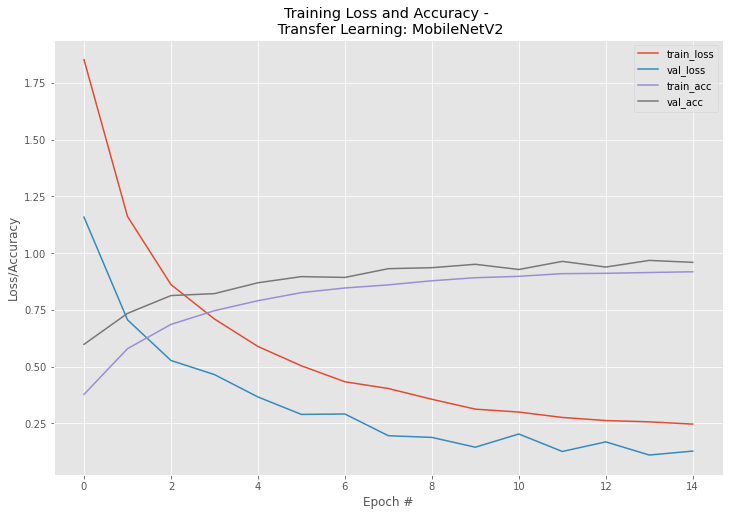

In [40]:
NET = 'MobileNetV2'
HIDDEN_LAYERS = [512, 128]
HIDDEN_LAYERS = [256, 256, 64]
CLASSES = len(set(target))
BATCH_SIZE = 100
EPOCHS = 15

model = mobileNetV2_class(train_val_test, NET, HIDDEN_LAYERS, CLASSES, EPOCHS, BATCH_SIZE)
model.run()

In [41]:
model.predict()


Predicting test set classes.
Test set score: [0.1327253133058548, 0.9609524011611938]
Done


### Confusion matrix of mobilenetV2

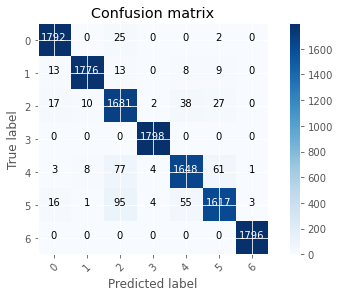

In [42]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Predict the values from the validation dataset
Y_pred = model.predictions
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
#Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))